In [3]:
#imports
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
#declare file path variables here
rl_f = os.path.abspath('../../../results/pat0_t1/rl.txt')
irl_f = os.path.abspath('../../results/mmp_proj_test/irl_p0s1.txt')#(iter, traj#, timestep, x[0], x[1], action (or S))

In [9]:
#gets values for plotting
#reward values change over time
def reward_var(file_name):
    rtn = []
    with open(file_name, 'r') as file:
        for line in file.read().split('_')[1:]:
            if line[0] != '0':
                line = ", ".join(line.split(", ")[:-1])
            #print("line: ", line)
                w = line.split('tensor([')[-1][:-1]#removes the final ")"
                rtn.append([float(a.rstrip()) for a in w[:-1].split(',')])
            else:
                w = line.split('tensor([')[-1][:-1]#removes the final ")"
                rtn.append([float(a.rstrip()) for a in w[:-2].split(',')])
    return rtn


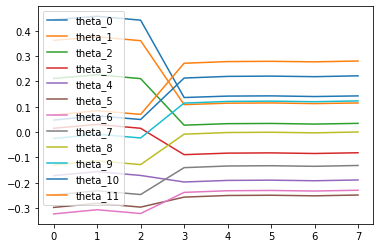

In [13]:
data = reward_var(irl_f)
plt.plot([i for i in range(len(data) - 1)], [x for x in data[1:]])
plt.legend(['theta_' + str(i) for i in range(len(data[0]))])

In [111]:
print(data[7][0] - data[6][0])
print(data[7][1] - data[6][1])
print(data[7][-1] - data[6][-1])

-0.0044000000000001815
-0.0043999999999999595
-0.0043999999999999595


In [113]:
torch.rand(12)

tensor([0.9571, 0.8429, 0.0794, 0.3872, 0.1317, 0.0418, 0.2202, 0.6521, 0.9243,
        0.2787, 0.3459, 0.8123])

In [57]:
#returns list, percentage of time in range for each iteration
def time_in_range(f_name, low, high):
    iters = -1
    total = 0
    rtn = []
    with open(f_name, 'r') as file:
        for line in file:
            curr_i, glucose = int(line.split(",")[0]), float(line.split(",")[3])
            if curr_i == iters:
                rtn[-1] += low <= glucose <= high
                total +=1
            else:
                if iters != -1:
                    rtn[-1] = rtn[-1]/total
                iters +=1
                total = 1
                rtn.append(low<= glucose <= high)
        rtn[-1] = rtn[-1]/total
    return rtn

In [74]:

def avg_glucose_reward(fpath_rl, fpath_irl, iters):
    ret = [] #list of (x, y) for each iteration to be plotted
    res_from_file = dict() #stores results from file
    reward_vals = dict()
    WINDOW_SIZE = 12

    #getting data from the rl_file
    with open(fpath_rl) as f_rl:
        for rl_line in f_rl:
            rl_iter = int(rl_line.split(", ")[0]) #irl iter of line in rl file
            if rl_iter in iters: #want to plot
                if rl_iter in res_from_file.keys():
                    res_from_file[rl_iter].append(float(rl_line.split(", ")[3]))
                else:
                    res_from_file[rl_iter] =[float(rl_line.split(", ")[3])]
    
    #getting data from the irl file
    with open(fpath_irl) as f_irl:
        lines = f_irl.read().split("_")[1:]
        for line in lines:
            rl_iter = int(line.split(", ")[0])
            if rl_iter in iters:#want to plot 
                reward_vals[rl_iter] = eval("torch." + (", ".join(line.split(",")[13:-1]))) #doesnt work for iteration 0
                
    
    #now we have the data, time to get what is to be plotted
    for iter in iters:
        x = []
        y = []
        w = reward_vals[iter]
        g_vals = np.array(res_from_file[iter])
        n = len(g_vals)
        for i in range(n - WINDOW_SIZE): #+1?
            curr_g = g_vals[i:i+WINDOW_SIZE]
            x.append(np.average(curr_g))
            y.append(np.tensordot(curr_g, w, 1))
        ret.append((x, y))
    
    return ret





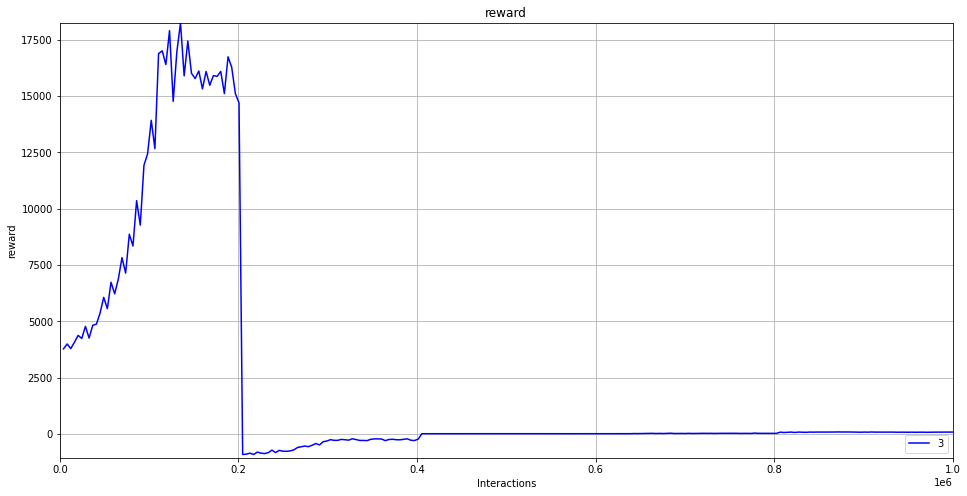

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
from decouple import config
# MAIN_PATH = config('MAIN_PATH')
MAIN_PATH = r'C:\Users\jtrim\OneDrive\Documents\COMP4550\RL4T1D'
sys.path.insert(1, MAIN_PATH)
from visualiser.core import ExperimentVisualise, plot_testing_rewards, plot_training_logs, plot_value_function
from visualiser.core import plot_episode, plot_training_action_summary, plot_training_logs
from visualiser.core import display_commands, plot_testing_metric, display_commands_v2, plot_testing_average_metric
import matplotlib.gridspec
%matplotlib inline 

# FOLDER = 'nci/May12/adult_easy/'
# ALGO = 'G'
# SUBJECT = '6'
PATH = 'p6s'
# COHORT = 'Adult'

# FOLDER = 'Aug24_04/'
# ALGO = 'IS'
# SUBJECT = '0'
# # PATH = FOLDER+ALGO+SUBJECT
# COHORT = 'Adult'

#PATH = 'test000'

#LABEL = COHORT+SUBJECT

exp1 = ExperimentVisualise(id=PATH+'1', version=1.1, plot_version=1, test_seeds=5000)
exp2 = ExperimentVisualise(id=PATH+'2', version=1.1, plot_version=1, test_seeds=5000)
exp3 = ExperimentVisualise(id=PATH+'3', version=1.1, plot_version=1, test_seeds=5000)

# plot the graphs
command = []
dis_len = 1.0 * 1000000
disp_arr = display_commands_v2(command)
exp_vis = {
             #'1':{ "id":exp1, "color":'r',"show": disp_arr[1], "label":'1'}, 
             #'2':{ "id":exp2, "color":'g',"show": disp_arr[2], "label":'2'},  
             '3':{ "id":exp3, "color":'b',"show": disp_arr[3], "label":'3'}, 
}
# average metric
#plot_testing_average_metric(exp_vis, [['1', '2', '3']], type='normal', dis_len=dis_len, metric='reward', goal=312, fill=True)

# #individual seed metrics
plot_testing_metric(exp_vis, type='normal', dis_len=dis_len, metric='reward', goal=312, fill=False, label=False)  # normal
# plot_testing_metric(exp_vis, type='min_max', dis_len=dis_len, metric='aBGP_rmse', goal=15, fill=False)
# #plot_testing_metric(exp_vis, type='min_max', dis_len=dis_len, metric='cBGP_rmse', goal=10, fill=False)
# # plot_testing_metric(exp_vis, type='min_max', dis_len=dis_len, metric='normo', goal=70, fill=False)  # normal
# plot_testing_metric(exp_vis, type='min_max', dis_len=dis_len, metric='ri', goal=5, fill=False)
# plot_testing_metric(exp_vis, type='min_max', dis_len=dis_len, metric='hgbi', goal=5, fill=False)
# plot_testing_metric(exp_vis, type='min_max', dis_len=dis_len, metric='lgbi', goal=1.1, fill=False)
# #plot_training_logs(exp_vis, dis_len, version=3)

# params = ['exp_var', 'true_var','val_loss', 'policy_grad', 'value_grad'] #, 'pi_loss'
# plot_training_logs(mode='ppo', exp_dict=exp_vis, dis_len=dis_len, params=params)
# params = ['pi_aux_grad'] #'pi_aux_loss', 'vf_aux_loss', vf_aux_grad 
# plot_training_logs(mode='aux', exp_dict=exp_vis, dis_len=250, params=params)

# params = ['plan_grad', 'plan_loss'] 
# # plot_training_logs(mode='planning', exp_dict=exp_vis, dis_len=250, params=params)    

In [172]:
f2 = os.path.abspath('../../results/p0s1/testing/worker_episode_6000.csv')
df2 = pd.read_csv(f2)

In [173]:
rew2 = df2.groupby('episode').sum()['rew']
counts2 = df2.groupby('episode').count()['t']

In [176]:
print(rew.add(rew2, fill_value = 0))

episode
1.0      13.878461
2.0       0.403039
3.0       4.453479
4.0      13.399080
5.0      -1.278428
           ...    
339.0    -0.313007
340.0    -0.352771
341.0    -0.290395
342.0    -0.567058
343.0    -0.987475
Name: rew, Length: 343, dtype: float64


In [177]:
rew

episode
1.0      1.759512
2.0      2.685371
3.0      1.385371
4.0      1.638785
5.0      2.792969
           ...   
339.0   -0.313007
340.0   -0.352771
341.0   -0.290395
342.0   -0.567058
343.0   -0.987475
Name: rew, Length: 343, dtype: float64

In [148]:
rew/counts

episode
1.0      0.056758
2.0      0.057136
3.0      0.069269
4.0      0.056510
5.0      0.063477
           ...   
339.0   -0.001087
340.0   -0.001225
341.0   -0.001008
342.0   -0.001969
343.0   -0.003644
Length: 343, dtype: float64

In [2]:
1e6

1000000.0

In [3]:
from environment.reward_func import *

composite_reward(args = None,state=116.651085)

0.9995473803044009